## BlackSheep Cookbook Exploration

The Black Sheep Analysis allows researchers to find trends in abnormal protein enrichment among patients in CPTAC datasets. In this Cookbook, we will go through the steps needed to perform a full Black Sheep Analysis.

### Step 1a: Import Dependencies
First, import the necessary dependencies and load cptac data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functions as bf
import blackSheepCPTACmoduleCopy as blsh
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot

Welcome to cptac, a python package for disseminating cancer
proteogenomics data. To view available datasets, enter
'cptac.list_data()'. Extensive tutorials are available at
https://github.com/PayneLab/cptac/tree/master/doc

******
Version: 0.4.5
******


## Step 1b: Load Data and Choose Omics Table
For this analysis, we will be looking at results across the proteomics, transcriptomics, and phosphoproteomics tables.

In [2]:
ov = cptac.Ovarian()
proteomics = ov.get_proteomics()
transcriptomics = ov.get_transcriptomics()
clinical = ov.get_clinical()

Checking that data files are up-to-date...
100% [..................................................................................] 407 / 407
Data check complete.
ovarian data version: Most recent release

Loading clinical data...
Loading cnv data...
Loading definitions data...
Loading phosphoproteomics data...
Loading proteomics data...
Loading somatic_38 data...
Loading transcriptomics data...
Loading treatment data...


## Step 2: Determine what attributes you would like to A/B test. 
For this analysis, we will iteratively go through the various columns in the clinical dataset, to determine if any of them have trends within them for protein enrichment.

In [3]:
#Create a copy of the original Clinical DataFrame
annotations = pd.DataFrame(clinical.copy())

In [4]:
#Drop irrelevant columns.
irrelevant_cols = ['Patient_ID', 'Participant_Gender', 'Histological_Subtype']
annotations = annotations.drop(irrelevant_cols, axis=1)

#Determine which columns we should either drop, or be generally skeptical of in our analysis
questionable_cols = ['Participant_History_Neo-adjuvant_Treatment', #all said no but one
                     'Participant_History_Radiation_Therapy', #all said no but one
                     'Participant_History_Hormonal_Therapy', #all said no but one
                     'Participant_Ethnicity', #all are not hispanic or latino, weren't evaluated, or unknown. Only one hispanic
                     'Normal_Sample_4_Surgical_Devascularized_Time', #very few datatpoints
                     'Normal_Sample_4_Weight', 'Normal_Sample_4_LN2_Time', #very few datapoints
                     'Normal_Sample_4_Ischemia_Time', #very few datapoints
                     'Normal_Sample_5_Surgical_Devascularized_Time', #very few datapoints
                     'Normal_Sample_5_Weight', 'Normal_Sample_5_LN2_Time', #very few datapoints
                     'Normal_Sample_5_Ischemia_Time', #very few datapoints
                     'Other_New_Tumor_Event_Site', #few datapoints, and hard to really binarize 
                     'Days_Between_Collection_And_New_Tumor_Event_Surgery'] #few datapoints

annotations = annotations.drop(questionable_cols, axis=1)
#Drop all the tumor sample columns Ask Sam about this on Thursday

In [5]:
#Determine which columns are binary and which aren't
binary_cols = []
non_binary_cols = []

for col in annotations.columns:
    if len(annotations[col].value_counts()) == 2:
        binary_cols.append(col)
    elif len(annotations[col].value_counts()) > 2:
        non_binary_cols.append(col)
    else:
        annotations = annotations.drop(col, axis=1) 
        #This would defeat the purpose of binarization if there were only 1 possible outcome.

In [6]:
numeric_non_bin = []
categorical_non_bin = []

for item in non_binary_cols:
    if np.issubdtype(annotations[item].dtype, np.number):
        print(item+" is a numeric column\n")
        numeric_non_bin.append(item)
        mean = annotations[item].mean()
        annotations[item]= bf.binarizeCutOff(annotations, item, mean, 
                                             "Above_Mean("+str(round(mean, 2))+")", 
                                             "Below_Mean("+str(round(mean, 2))+")")
    else:
        print(item+" is a categorical column\n")
        categorical_non_bin.append(item)

Participant_Procurement_Age is a numeric column

Participant_Race is a categorical column

Participant_Jewish_Heritage is a categorical column

Aliquots_Plasma is a numeric column

Blood_Collection_Time is a categorical column

Blood_Collection_Method is a categorical column

Anesthesia_Time is a numeric column

Tumor_Surgical_Devascularized_Time is a numeric column

Tumor_Sample_Number is a numeric column

Tumor_Sample_1_Weight is a numeric column

Tumor_Sample_1_LN2_Time is a numeric column

Tumor_Sample_1_Ischemia_Time is a numeric column

Tumor_Sample_2_Weight is a numeric column

Tumor_Sample_2_LN2_Time is a numeric column

Tumor_Sample_2_Ischemia_Time is a numeric column

Tumor_Sample_3_Weight is a numeric column

Tumor_Sample_3_LN2_Time is a numeric column

Tumor_Sample_3_Ischemia_Time is a numeric column

Tumor_Sample_4_Weight is a numeric column

Tumor_Sample_4_LN2_Time is a numeric column

Tumor_Sample_4_Ischemia_Time is a numeric column

Tumor_Sample_5_Weight is a numeric co

## Step 2a: Binarize column values

In [7]:
race_map = {'White':'White', 
            'Asian':'Not_White', 
            'Black or African American':'Not_White', 
            'Unknown (Could not be determined or unsure)':np.nan, 
            'American Indian or Alaska Native': 'Not_White'}

annotations['Participant_Race'] = bf.binarizeCategorical(annotations, 
                                                         'Participant_Race', 
                                                         race_map)

In [8]:
jewish_map = {'Not Jewish':'Not_Jewish', 
              'Unknown':np.nan, 
              'Ashkenazi':'Jewish', 
              'Jewish, NOS':'Jewish'}

annotations['Participant_Jewish_Heritage'] = bf.binarizeCategorical(annotations, 
                                                                    'Participant_Jewish_Heritage', 
                                                                    jewish_map)

In [9]:
#Replace categorical 'Not Reported/ Unknown' with NaN and convert to numeric for easier binarization
annotations['Blood_Collection_Time'] = annotations['Blood_Collection_Time'].replace('Not Reported/ Unknown', np.nan)
annotations['Blood_Collection_Time'] = pd.to_numeric(annotations['Blood_Collection_Time'])

#Binarize Column
annotations['Blood_Collection_Time'] = bf.binarizeCutOff(annotations, 
                                                         'Blood_Collection_Time', 
                                                         1000, 'Long', 'Short')

In [10]:
blood_collection_method_map = {'Venipuncture (Vacutainer Apparatus)':'Venipuncture', 
                               'Venipuncture (Syringe)':'Venipuncture', 'IV Catheter':'IV'}

annotations['Blood_Collection_Method'] = bf.binarizeCategorical(annotations, 
                                                                'Blood_Collection_Method', 
                                                                blood_collection_method_map)

In [11]:
origin_site_map = {'Ovary':'Ovary', 
                   'Fallopian tube':'Other', 
                   'Peritoneum':'Other'}

annotations['Origin_Site_Disease'] = bf.binarizeCategorical(annotations, 
                                                            'Origin_Site_Disease',
                                                            origin_site_map)

In [12]:
anatomic_site_map = {'Ovary':'Ovary', 
                     'Omentum':'Other', 
                     'Pelvic mass':'Other', 
                     'Peritoneum':'Other', 
                     'Not Reported/ Unknown':np.nan}

annotations['Anatomic_Site_Tumor'] = bf.binarizeCategorical(annotations, 
                                                            'Anatomic_Site_Tumor',
                                                            anatomic_site_map)

In [13]:
anatomic_lateral_map = {'Not applicable':'Other',
                        'Right':'Right',
                        'Left':'Other', 
                        'Not Reported/ Unknown':np.nan, 
                        'Bilateral':'Other'}

annotations['Anatomic_Lateral_Position_Tumor'] = bf.binarizeCategorical(annotations,
                                                                        'Anatomic_Lateral_Position_Tumor',
                                                                        anatomic_lateral_map)

In [14]:
path_diagnosis_map = {'Tumor resection': 'Tumor resection',
                      'Excisional Biopsy':'Biopsy', 
                      'Excisional Biopsy':'Biopsy'}

annotations['Method_of_Pathologic_Diagnosis'] = bf.binarizeCategorical(annotations,
                                                                       'Method_of_Pathologic_Diagnosis',
                                                                       path_diagnosis_map)

In [15]:
tumor_stage_map = {'IC':'I_or_II', 
                   'IIB':'I_or_II', 
                   'III':'III_or_IV', 
                   'IIIA':'III_or_IV', 
                   'IIIB':'III_or_IV', 
                   'IIIC':'III_or_IV', 
                   'IV':'III_or_IV', 
                   'Not Reported/ Unknown':np.nan}

annotations['Tumor_Stage_Ovary_FIGO'] = bf.binarizeCategorical(annotations, 
                                                               'Tumor_Stage_Ovary_FIGO', 
                                                               tumor_stage_map)

In [16]:
tumor_grade_map = {'G3':'G3', 'Not Reported/ Unknown':np.nan, 
                   'G2':'Other', 'G1':'Other', 
                   'GB':'Other', 'GX':'Other'}

annotations['Tumor_Grade'] = bf.binarizeCategorical(annotations, 
                                                    'Tumor_Grade', 
                                                    tumor_grade_map)

In [17]:
resid_max_diam_map = {'None':'0-10 mm', 
                      '1-10 mm': '0-10 mm', 
                      'greater than 20 mm':'greater than 11 mm', 
                      'Not Reported/ Unknown':np.nan, 
                      '11-20 mm':'greater than 11 mm'}

annotations['Tumor_Residual_Disease_Max_Diameter'] = bf.binarizeCategorical(annotations, 
                                                                            'Tumor_Residual_Disease_Max_Diameter', 
                                                                            resid_max_diam_map)

In [18]:
annotations['Tumor_Status'] = annotations['Tumor_Status'].replace('Not Reported/Unknown', np.nan)

In [19]:
annotations['Review_Of_Initial_Pathological_Findings'] = annotations['Review_Of_Initial_Pathological_Findings'].replace('Not Applicable', np.nan)

In [20]:
annotations['Adjuvant_Pharmaceutical_Therapy'] = annotations['Adjuvant_Pharmaceutical_Therapy'].replace('Not Reported/Unknown', np.nan)

In [21]:
annotations['Adjuvant_Immunotherapy'] = annotations['Adjuvant_Immunotherapy'].replace('Not Reported/Unknown', np.nan)

In [22]:
annotations['Adjuvant_Hormone_Therapy'] = annotations['Adjuvant_Hormone_Therapy'].replace('Not Reported/Unknown', np.nan)

In [23]:
annotations['Adjuvant_Targeted_Molecular_Therapy'] = annotations['Adjuvant_Targeted_Molecular_Therapy'].replace('Not Reported/Unknown', np.nan)

In [24]:
response_map = {'Complete Response':'Complete_or_Partial_Response', 
                'Partial Response':'Complete_or_Partial_Response', 
                'Stable Disease':'Stable_or_Progressive_Disease', 
                'Not Reported/Unknown':np.nan, 
                'Progressive Disease':'Stable_or_Progressive_Disease'}

annotations['Response_After_Surgery_And_Adjuvant_Therapies'] = bf.binarizeCategorical(annotations, 
                                                                                      'Response_After_Surgery_And_Adjuvant_Therapies', 
                                                                                      response_map)

In [25]:
new_tumor_map = {'No':'No', 'Yes':'Yes',
                 'Not Reported/Unknown':np.nan, 
                 'Not Applicable':np.nan}

annotations['New_Tumor_Event_After_Initial_Treatment'] = bf.binarizeCategorical(annotations, 
                                                                                'New_Tumor_Event_After_Initial_Treatment',
                                                                                new_tumor_map)

In [26]:
new_tumor_type_map = {'Locoregional Disease':'Locoregional_and_or_Distant_Metastasis', 
                      'Both Locoregional and Distant Metastasis':'Locoregional_and_or_Distant_Metastisis',
                      'Metastatic':'Metastatic', 'Not Reported/Unknown':np.nan}

annotations['New_Tumor_Event_Type'] = bf.binarizeCategorical(annotations,
                                                             'New_Tumor_Event_Type',
                                                             new_tumor_type_map)

In [27]:
new_tumor_site_map = {'Abdomen':'Abdomen', 
                      'Chest; Abdomen':'Abdomen', 
                      'Lymph Node only (specify location)':'Other', 
                      'Other (specify)':'Other', 
                      'Abdomen; Chest':'Abdomen', 
                      'Other (specify); Chest':'Other', 
                      'Abdomen; Other (specify); Pelvis':'Abdomen', 
                      'Pelvis; Abdomen':'Abdomen'}

annotations['New_Tumor_Event_Site'] = bf.binarizeCategorical(annotations,
                                                             'New_Tumor_Event_Site',
                                                             new_tumor_site_map)

In [28]:
diagnosis_map = {'Convincing imaging':'Convincing imaging', 
                 'Positive Biomarkers':'Biomarkers_or_Seen_at_Surgery', 
                 'First seen at further surgery':'Biomarkers_or_Seen_at_Surgery'}

annotations['New_Tumor_Event_Diagnosis'] = bf.binarizeCategorical(annotations, 
                                                                  'New_Tumor_Event_Diagnosis', 
                                                                  diagnosis_map)

In [29]:
annotations['New_Tumor_Event_Surgery'] = annotations['New_Tumor_Event_Surgery'].replace('Not Reported/Unknown', np.nan)

In [30]:
annotations['New_Tumor_Event_Chemotherapy'] = annotations['New_Tumor_Event_Chemotherapy'].replace('Not Reported/Unknown', np.nan)

In [31]:
annotations['New_Tumor_Event_Immunotherapy'] = annotations['New_Tumor_Event_Immunotherapy'].replace('Not Reported/Unknown', np.nan)

In [32]:
annotations['New_Tumor_Event_Targeted_Molecular_Therapy'] = annotations['New_Tumor_Event_Targeted_Molecular_Therapy'].replace('Not Reported/Unknown', np.nan)

## Step 3: Perform outliers analysis

In [33]:
outliers_prot = blsh.make_outliers_table(proteomics, iqrs=1.5, 
                                         up_or_down='up', 
                                         aggregate=False, 
                                         frac_table=False)

outliers_trans = blsh.make_outliers_table(transcriptomics, iqrs=1.5, 
                                          up_or_down='up', 
                                          aggregate=False, 
                                          frac_table=False)

In [34]:
#Deal with duplicate columns problem
bf.renameDuplicateColumns(outliers_prot)

## Step 4: Wrap your A/B test into the outliers analysis, and create a table
First for proteomics, and then phosphoproteomics.

In [35]:
#Breaks here because of indexing errors
results_prot = blsh.compare_groups_outliers(outliers_prot, 
                                            annotations)

No rows had outliers in at least 0.3 of Participant_Procurement_Age Below_Mean(713.75) samples
No rows had outliers in at least 0.3 of Participant_Procurement_Age Above_Mean(713.75) samples
No rows had outliers in at least 0.3 of Sample_Tumor_Normal Tumor samples
Testing 546 rows for enrichment in Sample_Tumor_Normal Normal samples
No rows had outliers in at least 0.3 of Participant_Race White samples
Testing 91 rows for enrichment in Participant_Race Not_White samples
No rows had outliers in at least 0.3 of Participant_Jewish_Heritage Not_Jewish samples
Testing 9 rows for enrichment in Participant_Jewish_Heritage Jewish samples
No rows had outliers in at least 0.3 of Participant_History_Malignancy No samples
Testing 126 rows for enrichment in Participant_History_Malignancy Yes, History of Other Cancer Greater Than One Year Ago samples
No rows had outliers in at least 0.3 of Participant_History_Chemotherapy No samples
Testing 159 rows for enrichment in Participant_History_Chemotherapy 

No rows had outliers in at least 0.3 of Days_Between_Collection_And_Last_Contact Below_Mean(404.27) samples
Testing 6 rows for enrichment in Days_Between_Collection_And_Last_Contact Above_Mean(404.27) samples
No rows had outliers in at least 0.3 of Vital_Status Living samples
Testing 23 rows for enrichment in Vital_Status Deceased samples
Testing 160 rows for enrichment in Days_Between_Collection_And_Death Below_Mean(585.62) samples
Testing 468 rows for enrichment in Days_Between_Collection_And_Death Above_Mean(585.62) samples
No rows had outliers in at least 0.3 of Tumor_Status Tumor free samples
No rows had outliers in at least 0.3 of Tumor_Status With tumor samples
No rows had outliers in at least 0.3 of Review_Of_Initial_Pathological_Findings Yes samples
Testing 126 rows for enrichment in Review_Of_Initial_Pathological_Findings No samples
No rows had outliers in at least 0.3 of Pathology_Review_Consistent_With_Diagnosis Yes samples
Testing 1050 rows for enrichment in Pathology_Revi

In [36]:
#results_trans = blsh.compare_groups_outliers(outliers_trans, 
#                                             annotations)

Many of the output values from compare_group_outliers are NaN, so here we will get rid of the NaN values for visualization purposes.

In [37]:
results_prot = results_prot.dropna(axis=0, how='all')
#results_trans = results_trans.dropna(axis=0, how='all')

## Step 5: Visualize these enrichments

In [38]:
#Drop Columns with less than 5 significant enrichments
print("TESTING FOR PROTEOMICS:")
sig_cols = []
for col in results_prot.columns:
    sig_col = bf.significantEnrichments(results_prot, col, 0.01)
    if sig_col is not None and len(sig_col) >= 5:
        sig_cols.append(sig_col)
        print(sig_col)
    else:
        results_prot = results_prot.drop(col, axis=1)

'''
Trying to create a dataframe of just columns with more than 10 enrichments
sig_results_prot = pd.DataFrame()
for col in sig_cols:
    sig_results_prot[col]
'''

TESTING FOR PROTEOMICS:
538 significant protein enrichments in Sample_Tumor_Normal_Normal

          Sample_Tumor_Normal_Normal_P_values
A1BG                             1.530112e-06
ABCA8                            7.415921e-09
ABHD5                            2.160272e-03
ABI3BP                           2.768223e-07
ABL1                             2.141254e-04
ACACA                            6.522580e-03
ACADS                            6.638046e-04
ACE                              4.470259e-05
ACOT1                            2.141254e-04
ACOT2                            2.141254e-04
ACSL1                            4.470259e-05
ACSL1(1)                         4.470259e-05
ACSL5                            1.645922e-03
ACSL6                            6.522580e-03
ACSS2                            1.645922e-03
ACTA1                            1.672134e-06
ACTA2                            1.672134e-06
ACTBL2                           4.470259e-05
ACTG2                            1.

'\nTrying to create a dataframe of just columns with more than 10 enrichments\nsig_results_prot = pd.DataFrame()\nfor col in sig_cols:\n    sig_results_prot[col]\n'

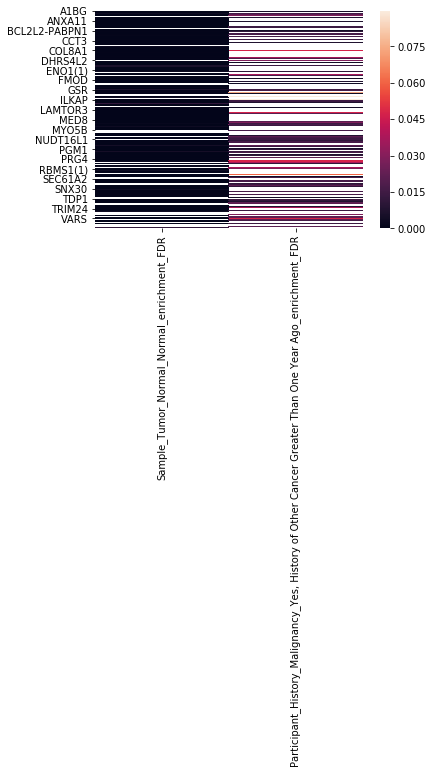

In [39]:
sns.heatmap(results_prot)
plt.show()

In [40]:
#sns.heatmap(results_trans)
#plt.show()

## Step 6: Determine significant enrichments, and link with cancer drug database.

In [41]:
'''for col in sig_cols:
    col_name = col.columns[0]
    gene_name_list = list(col.index)
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human', 
                            outdir='test/enrichr_kegg', #This isn't saving correctly...why is that?
                            cutoff=0.5)
    print(enrichment.res2d)
    barplot(enrichment.res2d, title=col_name)
'''

"for col in sig_cols:\n    col_name = col.columns[0]\n    gene_name_list = list(col.index)\n    enrichment = gp.enrichr(gene_list = gene_name_list, \n                            description=col_name, \n                            gene_sets='KEGG_2019_Human', \n                            outdir='test/enrichr_kegg', #This isn't saving correctly...why is that?\n                            cutoff=0.5)\n    print(enrichment.res2d)\n    barplot(enrichment.res2d, title=col_name)\n"